In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase import build
import matplotlib.pyplot as plt

import numpy as np
from abtem import *

import cupy

# fft cache disabled for large simulations
from cupy.fft.config import get_plan_cache
cache = get_plan_cache()
cache.set_size(0)

current version: 1.0.0beta27


<ipython-input-1-8084aec3c69b>:16: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


# Large CBED simulation

In this example we calculate a CBED pattern with a sample consisting of silicon with 8.1 million atoms and a potential discretized on 10000x4096x4096 voxels. On our system the simulation time was 2 min on a single NVidia RTX 2080 Ti.

In [135]:
silicon_unit = build.bulk('Si', crystalstructure='diamond', cubic=True)
print(silicon.cell)
silicon = silicon_unit * (36,36,90)

Cell([195.48, 195.48, 488.7])


In [126]:
silicon.cell, len(silicon)

(Cell([195.48, 195.48, 488.7]), 933120)

In [127]:
# to simulate tds increase the number of frozen phonon configurations and set the sigma of the atomic vibrations

fp = FrozenPhonons(silicon, 
                   16, 
                   {'Si': 0.1}, 
                   seed=13, 
                   directions='xyz')

potential = Potential(silicon,
                      gpts=2048, 
                      device='gpu',
                      projection='infinite',
                      slice_thickness=.5,
                      precalculate=False,
                      parametrization='kirkland')

In [129]:
probe = Probe(energy=100e3, device='gpu', semiangle_cutoff=20, rolloff=0.)

probe.grid.match(potential)

#wave = probe.build((1,1))

In [130]:
detector = PixelatedDetector(max_angle=30)

In [139]:
#measurement = wave.multislice(potential, pbar=True, max_batch_potential=1, detector=detector)

In [ ]:
gridscan = GridScan(start=(0,0), end=np.diag(silicon_unit.cell)[:2], sampling=probe.ctf.nyquist_sampling*.9)

measurement = probe.scan(gridscan, detector, potential, pbar=True)

Scan:   0%|          | 0/169 [00:00<?, ?it/s]

In [134]:
#wave.show(figsize=(12,12), power=.4)

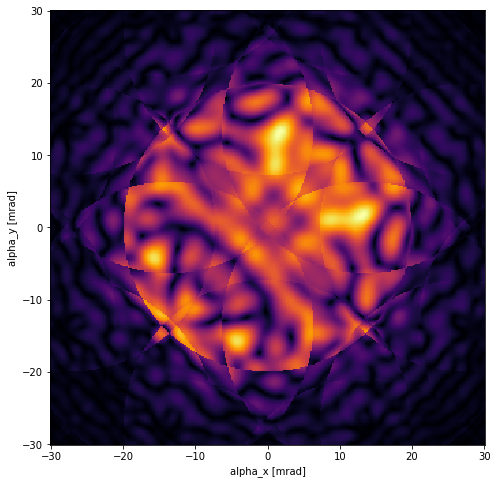

In [133]:
ax, im = measurement.show(figsize=(8,8), power=.5, cmap='inferno')

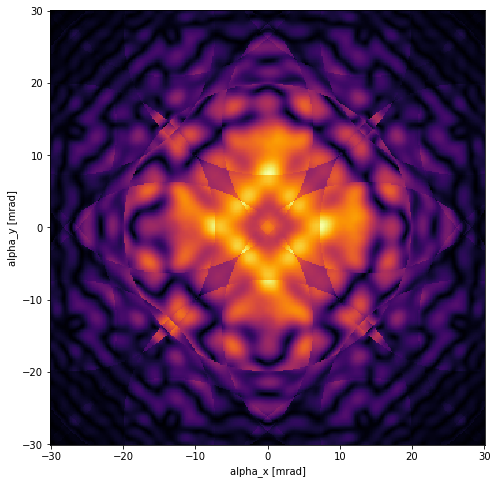

In [116]:
#measurement = wave.diffraction_pattern('limit').mean(0)
ax, im = measurement.show(figsize=(8,8), power=.5, cmap='inferno')

(-25.0, 25.0)

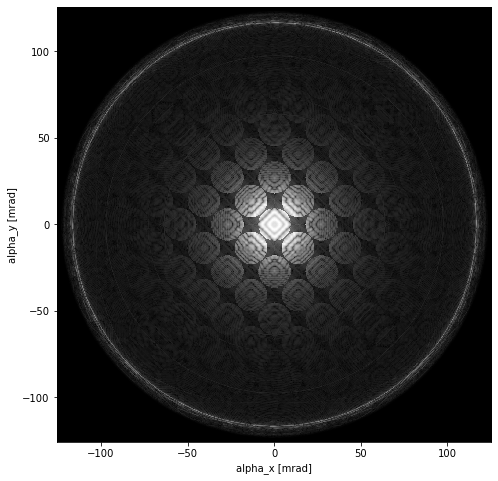

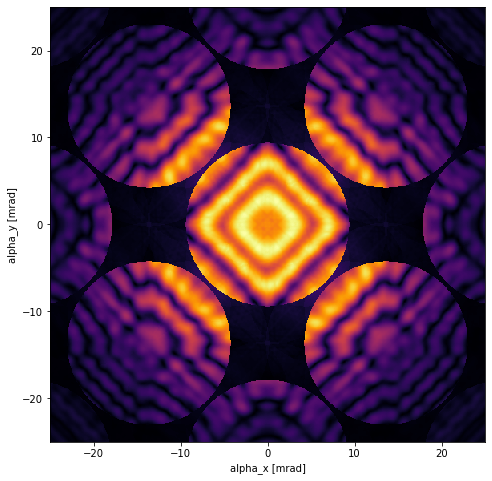

In [49]:
measurement = wave.diffraction_pattern('limit').mean(0)

ax, im = measurement.show(figsize=(8,8), power=.2)

ax, im = measurement.show(figsize=(8,8), power=.5, cmap='inferno')

ax.set_xlim([-25,25])
ax.set_ylim([-25,25])